In [1]:
import gc, random, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_theme()

from matplotlib.ticker import FixedLocator, FixedFormatter

from sklearn.cluster import DBSCAN, KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture
from sklearn.decomposition import PCA
from sklearn import metrics

from scipy import stats
from scipy.stats import norm

import lightgbm as lgb
import xgboost as xgb
import catboost as cb

import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks

import optuna

## Seed everything

In [2]:
seed = 42

os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)

## Load Data

In [3]:
df = pd.read_csv('../../../Data/Tabular Playground Series/tabular-playground-series-jul-2022/data.csv')
df.shape

(98000, 30)

In [4]:
df.head(2)

,id,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,...,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28
0,0,-0.389420,-0.912791,0.648951,0.589045,-0.830817,0.733624,2.258560,2,13,...,-0.478412,-0.757002,-0.763635,-1.090369,1.142641,-0.884274,1.137896,1.309073,1.463002,0.813527
1,1,-0.689249,-0.453954,0.654175,0.995248,-1.653020,0.863810,-0.090651,2,3,...,-0.428791,-0.089908,-1.784204,-0.839474,0.459685,1.759412,-0.275422,-0.852168,0.562457,-2.680541


In [5]:
X_train = df.drop('id', axis=1)

In [6]:
X_train.head(2)

,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,f_09,...,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28
0,-0.389420,-0.912791,0.648951,0.589045,-0.830817,0.733624,2.258560,2,13,14,...,-0.478412,-0.757002,-0.763635,-1.090369,1.142641,-0.884274,1.137896,1.309073,1.463002,0.813527
1,-0.689249,-0.453954,0.654175,0.995248,-1.653020,0.863810,-0.090651,2,3,6,...,-0.428791,-0.089908,-1.784204,-0.839474,0.459685,1.759412,-0.275422,-0.852168,0.562457,-2.680541


In [7]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
f_00,98000.0,0.001220,1.002801,-4.732235,-0.675226,0.002022,0.677271,4.490521
f_01,98000.0,0.005580,1.000742,-4.202795,-0.670985,0.006650,0.677746,4.324974
f_02,98000.0,-0.001042,1.001373,-4.377021,-0.672779,-0.000324,0.677086,4.560247
f_03,98000.0,-0.000700,1.000422,-4.010826,-0.672540,-0.003185,0.672097,4.399373
f_04,98000.0,-0.003522,1.003061,-4.535903,-0.682510,-0.003307,0.677589,4.050549
f_05,98000.0,-0.001612,1.000532,-4.300767,-0.675066,0.001024,0.673344,4.710316
f_06,98000.0,-0.003042,0.997434,-4.894525,-0.680421,-0.002053,0.668112,3.998595
f_07,98000.0,5.545918,3.691840,0.000000,3.000000,5.000000,8.000000,32.000000
f_08,98000.0,6.763061,4.152348,0.000000,4.000000,6.000000,9.000000,30.000000
f_09,98000.0,8.193163,5.904919,0.000000,4.000000,7.000000,11.000000,44.000000


In [8]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98000 entries, 0 to 97999
Data columns (total 29 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f_00    98000 non-null  float64
 1   f_01    98000 non-null  float64
 2   f_02    98000 non-null  float64
 3   f_03    98000 non-null  float64
 4   f_04    98000 non-null  float64
 5   f_05    98000 non-null  float64
 6   f_06    98000 non-null  float64
 7   f_07    98000 non-null  int64  
 8   f_08    98000 non-null  int64  
 9   f_09    98000 non-null  int64  
 10  f_10    98000 non-null  int64  
 11  f_11    98000 non-null  int64  
 12  f_12    98000 non-null  int64  
 13  f_13    98000 non-null  int64  
 14  f_14    98000 non-null  float64
 15  f_15    98000 non-null  float64
 16  f_16    98000 non-null  float64
 17  f_17    98000 non-null  float64
 18  f_18    98000 non-null  float64
 19  f_19    98000 non-null  float64
 20  f_20    98000 non-null  float64
 21  f_21    98000 non-null  float64
 22

<AxesSubplot:>

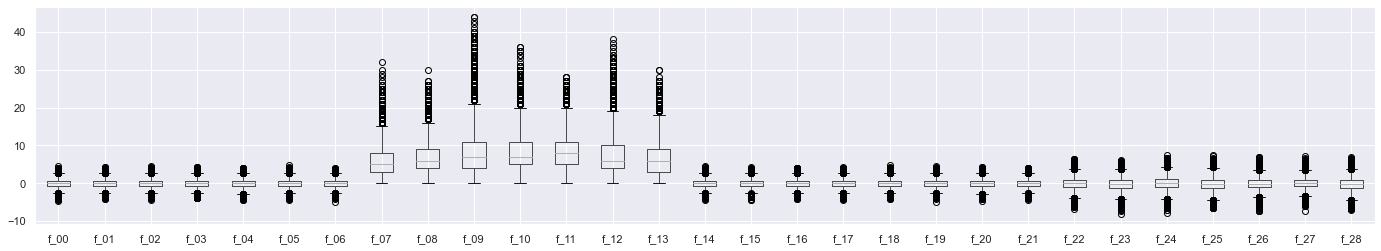

In [9]:
X_train.boxplot(figsize=(24,4))

## Probably a good idea to scale the data

In [10]:
# standard_scaler = StandardScaler()
# X_train = pd.DataFrame(standard_scaler.fit_transform(X_train), columns=X_train.columns)

power_transformer = PowerTransformer()
X_train = pd.DataFrame(power_transformer.fit_transform(X_train), columns=X_train.columns)
X_train.head(2)

,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,f_09,...,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28
0,-0.389230,-0.917652,0.647948,0.590717,-0.824836,0.734685,2.259470,-0.977987,1.383372,1.039938,...,-0.472922,-0.753925,-0.763110,-0.707876,0.911477,-0.678852,0.768543,0.960344,1.042536,0.694234
1,-0.688368,-0.458647,0.653182,0.995359,-1.644030,0.864898,-0.085604,-0.977987,-0.875405,-0.179925,...,-0.423594,-0.088164,-1.777545,-0.535582,0.453824,1.031505,-0.117686,-0.550783,0.367242,-1.636652


<AxesSubplot:>

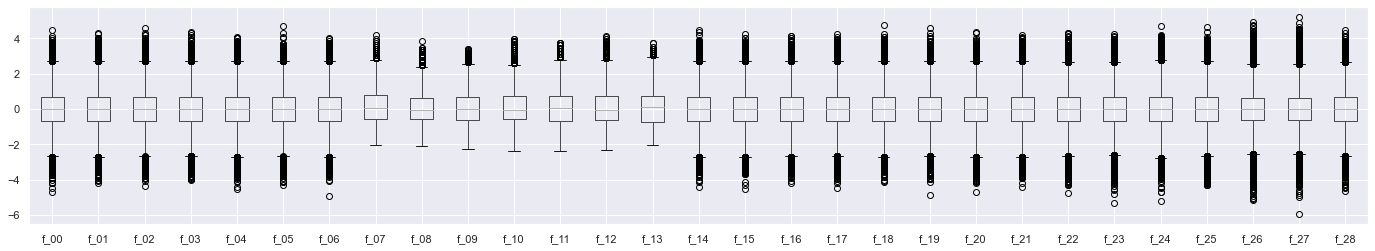

In [11]:
X_train.boxplot(figsize=(24,4))

In [12]:
# for col in X_train.columns:    
#     plt.figure(figsize=(5,5))
#     res = stats.probplot(X_train[col], plot=plt)

## DBSCAN

* it's hard to pick the right eps and min_samples to get exactly 7 clusters

In [13]:
# Epsilon = np.linspace(0.05, 10, 20)
# Min_Samples = [5]

# sil_scores = {}

# for eps in Epsilon:
#     for min_samples in Min_Samples:    
        
#         dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='cosine')
#         dbscan.fit(X_train)
#         num_clusters = len(np.unique(dbscan.labels_))
        
#         if num_clusters == 1:
#             print(f'eps={eps} | min_samples={min_samples} | number of clusters = {num_clusters}')
#             break
#         else:
#             sil_score = silhouette_score(X_train, dbscan.labels_)
#             sil_scores[(eps,min_samples)] = sil_score
#             print(f'eps={np.round(eps,4)} | min_samples={min_samples} | number of clusters = {num_clusters} | silhouette_score = {sil_score}')

## K-Means

### Let's try K-means on unscaled data

In [44]:
kmeans = KMeans(n_clusters=7, n_init=10, max_iter=300, random_state=seed)

kmeans.fit(df.drop('id', axis=1))

KMeans(n_clusters=7, random_state=42)

In [45]:
submission = pd.read_csv('../../../Data/Tabular Playground Series/tabular-playground-series-jul-2022/sample_submission.csv')
submission['Predicted'] = kmeans.predict(X_train)
submission.to_csv("submission.csv", index=False)

### This results in a very poor leaderboard score

### Leaderboard Score

<img src="k-means-7-clusters-unscaled.png">

### Now, let's try K-means on scaled data

In [46]:
kmeans = KMeans(n_clusters=7, n_init=10, max_iter=300, random_state=seed)

kmeans.fit(X_train)

KMeans(n_clusters=7, random_state=42)

In [47]:
submission = pd.read_csv('../../../Data/Tabular Playground Series/tabular-playground-series-jul-2022/sample_submission.csv')
submission['Predicted'] = kmeans.predict(X_train)
submission.to_csv("submission.csv", index=False)

### K-Means on scaled data is better, but still the score is very poor

### Leaderboard Score

<img src="k-means-7-clusters-scaled.png">

## Gaussian Mixture

* I tried n_components from 2 to 19 and gm's aic/bic scores did not show me what was the optimal number of clusters

In [51]:
# aic = []
# bic = []

# for n in range(2,20):    
    
#     gm = GaussianMixture(
#         n_components=n, 
#         covariance_type='full',
#         max_iter=300,
#         random_state=seed,
#         n_init=10,
#     )

#     gm.fit(X_train)
    
#     print(f'n_components={n} | Converged: {gm.converged_} | gm.weights_={gm.weights_}')
 
#     aic.append(gm.aic(X_train))
#     bic.append(gm.bic(X_train))    

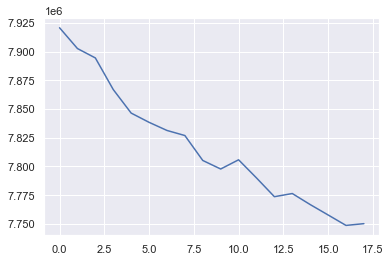

In [38]:
plt.plot(aic)

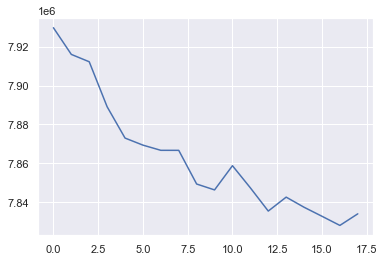

In [39]:
plt.plot(bic)

## Bayesian Gaussian Mixture

* I ran BGM with 2-14 clusters and looked at the cluster weights. The model consistently picks up that there are exactly 7 clusters when n_clusters > 7
* This proves that there are 7 clusters
* Note that some people tried to look at silhouette_score to assess the clustering quality, but silhouette_score is not a good measure for clusters produced by a BGM model. It's more of a measure for K-Means. 
* I also looked at silhouette_score depending on the number of clusters and I confirm it doesn't work. See HOML2 page 267. 

In [40]:
for n in range(2,15):
    bgm = BayesianGaussianMixture(
        n_components=n, 
        covariance_type='full', 
        max_iter=300, 
        random_state=seed, 
        n_init=10
    )

    bgm.fit(X_train)
    
    print(f'n_components={n} | Converged: {bgm.converged_} | bgm.weights_={bgm.weights_}')

n_components=2 | Converged: True | bgm.weights_=[0.55336502 0.44663498]
n_components=3 | Converged: True | bgm.weights_=[0.50308969 0.36830055 0.12860975]


C:\Users\yurit\anaconda3\envs\ml\lib\site-packages\sklearn\mixture\_base.py:265: ConvergenceWarning: Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '


n_components=4 | Converged: False | bgm.weights_=[0.29078419 0.28828509 0.19228251 0.22864821]


C:\Users\yurit\anaconda3\envs\ml\lib\site-packages\sklearn\mixture\_base.py:265: ConvergenceWarning: Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '


n_components=5 | Converged: False | bgm.weights_=[0.23432007 0.22473966 0.14793518 0.28840897 0.10459612]
n_components=6 | Converged: True | bgm.weights_=[0.22487064 0.21983356 0.1713162  0.11005515 0.14197884 0.13194561]
n_components=7 | Converged: True | bgm.weights_=[0.16313081 0.16216267 0.13239644 0.16845291 0.11895164 0.13840276
 0.11650278]
n_components=8 | Converged: True | bgm.weights_=[0.03666162 0.13725724 0.11640445 0.16925412 0.08367377 0.16234201
 0.16192551 0.13248128]
n_components=9 | Converged: True | bgm.weights_=[0.02607927 0.09192113 0.13058398 0.13292735 0.12497994 0.11710999
 0.16975888 0.04757062 0.15906883]
n_components=10 | Converged: True | bgm.weights_=[0.13099743 0.13488979 0.02840725 0.13313074 0.13792428 0.11345336
 0.0260834  0.13035151 0.13742947 0.02733277]
n_components=11 | Converged: True | bgm.weights_=[0.0937529  0.13320518 0.11056695 0.02806175 0.02736319 0.13095325
 0.12484145 0.0479973  0.16929022 0.02608078 0.10788703]
n_components=12 | Converge

#### Out of 14 cluster weights, 7 weights are close to zero and 7 are not, which illustrates that there are 7 clusters

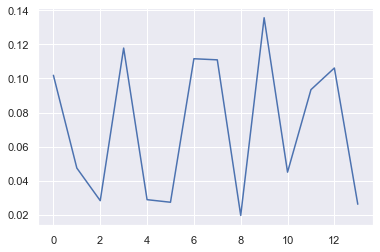

In [42]:
plt.plot([0.10187775, 0.0473885,  0.02823134, 0.11787482, 0.0288159,  0.02730286, 0.11160323, 0.110954,   0.0195677,  0.13568445, 0.04496927, 0.09343517, 0.10616244, 0.02613257])

## Let's looks at BGM leaderboard result on exactly 7 clusters

In [14]:
bgm = BayesianGaussianMixture(
    n_components=7, 
    covariance_type='full', 
    max_iter=300, 
    random_state=seed, 
    n_init=15
)

bgm.fit(X_train)

BayesianGaussianMixture(max_iter=300, n_components=7, n_init=15,
                        random_state=42)

In [15]:
bgm.converged_

True

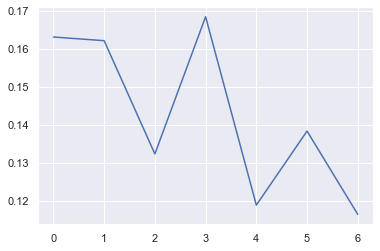

In [16]:
plt.plot(bgm.weights_)

In [55]:
submission = pd.read_csv('../../../Data/Tabular Playground Series/tabular-playground-series-jul-2022/sample_submission.csv')
submission['Predicted'] = bgm.predict(X_train)
submission.to_csv("submission.csv", index=False)

## A significant improvement vs. previous models!

### Leaderboard Score

<img src="bgm-7-clusters-scaled.png">

# Let's examine which features are useful

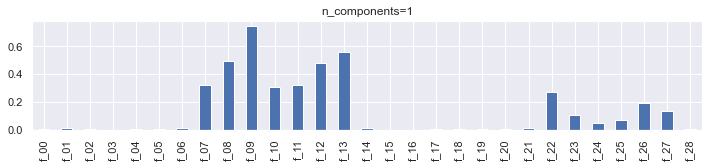

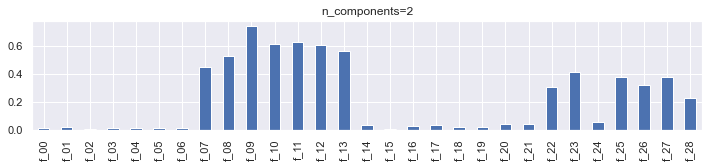

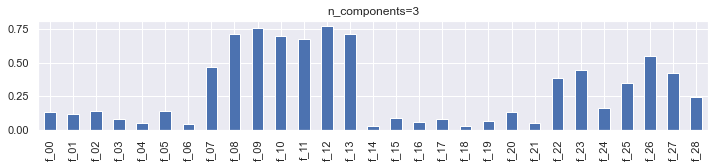

In [17]:
for n in range(1,4):
    pca = PCA(n_components=n, random_state=seed)

    p = pca.fit_transform(X_train)

    inv_transform = pca.inverse_transform(p)

    plt.figure(figsize=(12,2))
    pd.DataFrame(inv_transform, columns=X_train.columns).std().plot.bar(title=f'n_components={n}')

In [18]:
most_var_features = ['f_07','f_08','f_09','f_10','f_11','f_12','f_13','f_22','f_23','f_24','f_25','f_26','f_27','f_28']

In [ ]:
bgm = BayesianGaussianMixture(
    n_components=7, 
    covariance_type='full', 
    max_iter=300, 
    random_state=seed, 
    n_init=15
)

bgm.fit(X_train[most_var_features])

In [93]:
bgm.converged_

True

### It seems reducing the number of features also reduces the number of clusters that BGM recognizes (see weight #3 comes out to be very close to 0)

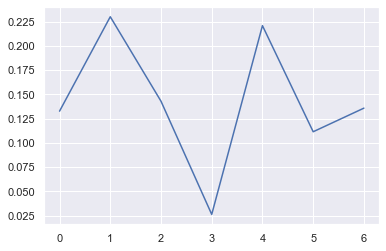

In [94]:
plt.plot(bgm.weights_)

In [95]:
submission = pd.read_csv('../../../Data/Tabular Playground Series/tabular-playground-series-jul-2022/sample_submission.csv')
submission['Predicted'] = bgm.predict(X_train[most_var_features])
submission.to_csv("submission.csv", index=False)

## Reducing number of features decreses LB Score and it also seems the data loses one cluster (see weights chart above)

### Leaderboard Score

<img src="bgm-7-clusters-scaled-reduced.png">

## There are 7 features which only take integer values

* after PowerTransform, they are no longer integer features in X_train

In [19]:
int_features = ['f_07','f_08','f_09','f_10','f_11','f_12','f_13']

In [20]:
df[int_features].head()

,f_07,f_08,f_09,f_10,f_11,f_12,f_13
0,2,13,14,5,13,6,6
1,2,3,6,4,6,16,9
2,5,11,5,8,9,3,11
3,6,2,13,8,9,6,4
4,8,7,5,3,1,13,11


In [21]:
X_train[int_features].head()

,f_07,f_08,f_09,f_10,f_11,f_12,f_13
0,-0.977987,1.383372,1.039938,-0.567775,1.142180,-0.083596,0.086073
1,-0.977987,-0.875405,-0.179925,-0.837020,-0.420725,1.725834,0.738456
2,0.021718,1.017648,-0.394246,0.124844,0.296135,-0.928325,1.118063
3,0.286548,-1.213526,0.917564,0.124844,0.296135,-0.083596,-0.434221
4,0.756900,0.187543,-0.394246,-1.135381,-1.954502,1.271662,1.118063


In [22]:
for feat in int_features:
    print(f'{feat}: {df[feat].nunique()}')

f_07: 32
f_08: 29
f_09: 45
f_10: 37
f_11: 29
f_12: 39
f_13: 30


### We might want to explore stricking int_features into CatBoost without PowerTransform as categorical features

In [23]:
for feat in int_features:
    print(f'{feat}:')
    print(f'{df[feat].sort_values().unique()}')
    print('\n')

f_07:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 32]


f_08:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 30]


f_09:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44]


f_10:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36]


f_11:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28]


f_12:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38]


f_13:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 30]




## Let's use BGM on 7 clusters to build a supervised learning problem

In [24]:
bgm = BayesianGaussianMixture(
    n_components=7, 
    covariance_type='full', 
    max_iter=300, 
    random_state=seed, 
    n_init=15
)

bgm.fit(X_train)

BayesianGaussianMixture(max_iter=300, n_components=7, n_init=15,
                        random_state=42)

In [25]:
bgm.converged_

True

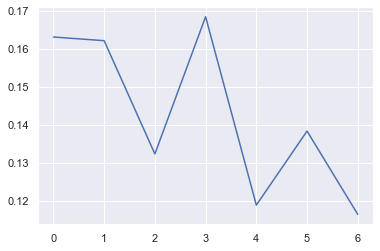

In [26]:
plt.plot(bgm.weights_)

In [27]:
y_train = bgm.predict(X_train)
proba = bgm.predict_proba(X_train)

In [28]:
y_train[:5]

array([5, 4, 5, 2, 3], dtype=int64)

In [29]:
np.round(proba[:10],2)

array([[0.  , 0.  , 0.  , 0.  , 0.01, 0.98, 0.  ],
       [0.05, 0.  , 0.02, 0.01, 0.9 , 0.  , 0.02],
       [0.  , 0.11, 0.  , 0.  , 0.  , 0.89, 0.  ],
       [0.01, 0.08, 0.87, 0.03, 0.01, 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.98, 0.02, 0.  , 0.  ],
       [0.02, 0.  , 0.  , 0.22, 0.73, 0.  , 0.03],
       [0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.04, 0.  , 0.  , 0.02, 0.92, 0.  ],
       [0.02, 0.  , 0.  , 0.  , 0.78, 0.2 , 0.  ],
       [0.6 , 0.  , 0.  , 0.  , 0.  , 0.4 , 0.  ]])

In [30]:
max_proba = np.max(proba,axis=1)

In [31]:
max_proba[:10]

array([0.97786138, 0.90289198, 0.88644387, 0.86863027, 0.98283882,
       0.72572435, 0.99722166, 0.92475382, 0.77867506, 0.59579212])

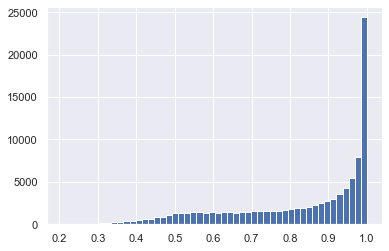

In [32]:
_ = plt.hist(max_proba, bins=50)

<AxesSubplot:>

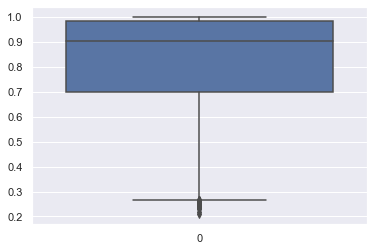

In [33]:
sns.boxplot(data=max_proba)

In [34]:
sure_idx = max_proba >= 0.8

In [35]:
sure_samples = X_train[sure_idx]
sure_y = y_train[sure_idx]
print(f'sure_samples.shape={sure_samples.shape}')
print(f'sure_y.shape={sure_y.shape}')

sure_samples.shape=(63109, 29)
sure_y.shape=(63109,)


In [36]:
sure_samples.head(2)

,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,f_09,...,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28
0,-0.389230,-0.917652,0.647948,0.590717,-0.824836,0.734685,2.259470,-0.977987,1.383372,1.039938,...,-0.472922,-0.753925,-0.763110,-0.707876,0.911477,-0.678852,0.768543,0.960344,1.042536,0.694234
1,-0.688368,-0.458647,0.653182,0.995359,-1.644030,0.864898,-0.085604,-0.977987,-0.875405,-0.179925,...,-0.423594,-0.088164,-1.777545,-0.535582,0.453824,1.031505,-0.117686,-0.550783,0.367242,-1.636652


In [37]:
cat_features = []

for i, col in enumerate(X_train.columns.tolist()):
    if col in int_features:
        cat_features.append(i)
        
cat_features

[7, 8, 9, 10, 11, 12, 13]

In [38]:
def objective(trial, n_splits=10, shuffle=True, get_info=False):
    
    param = {        
        'verbose': 0,
        'random_state': seed,
        'loss_function': 'MultiClass',
        'task_type': 'GPU',
        'iterations': trial.suggest_int('iterations', 10, 1000, 10),
        'depth': trial.suggest_int('depth', 1, 8),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1),
        'random_strength': trial.suggest_uniform('random_strength', 1e-9, 10),
        'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0, 1),
        'border_count': trial.suggest_int('border_count', 1, 255),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 30),
    }
    
    model = cb.CatBoostClassifier(**param)
    
    kf = StratifiedKFold(n_splits=n_splits, shuffle=shuffle, random_state=seed)    
    
    scores = []
    models = []

    for train_index, test_index in kf.split(sure_samples, sure_y): 

        train_dataset = cb.Pool(
            data=sure_samples.iloc[train_index,:], 
            label=sure_y[train_index],
#             cat_features=cat_features
        )
        
        eval_dataset = cb.Pool(
            data=sure_samples.iloc[test_index,:], 
            label=sure_y[test_index],
#             cat_features=cat_features
        )
        
        model.fit(
            train_dataset,            
            early_stopping_rounds=200,
            verbose=0,            
        )

        y_test_pred = model.predict(eval_dataset).reshape(-1)
        
        score = metrics.adjusted_rand_score(
            labels_true=sure_y[test_index],
            labels_pred=y_test_pred
        )
        
        scores.append(score)
        models.append(model)

    scores = np.array(scores)
    
    if get_info:
        
        info = {
            'mean_score': np.mean(scores), 
            'score_std' : np.std(scores), 
            'scores': scores, 
            'models': models,
        }
        
        return info
    else:
        return np.mean(scores)

In [39]:
study = optuna.create_study(direction='maximize', study_name='tps_clustering')
study.optimize(objective, n_trials=10, show_progress_bar=True)

[I 2022-07-19 19:24:03,903] A new study created in memory with name: tps_clustering
C:\Users\yurit\anaconda3\envs\ml\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-07-19 19:24:29,502] Trial 0 finished with value: 0.9788835816882455 and parameters: {'iterations': 460, 'depth': 3, 'learning_rate': 0.14011208895542743, 'random_strength': 2.4802425658415634, 'bagging_temperature': 0.37539110204207715, 'border_count': 220, 'l2_leaf_reg': 1.426200156510895}. Best is trial 0 with value: 0.9788835816882455.
[I 2022-07-19 19:25:02,146] Trial 1 finished with value: 0.8099277806440448 and parameters: {'iterations': 650, 'depth': 3, 'learning_rate': 0.011531789807335331, 'random_strength': 9.68607407990071, 'bagging_temperature': 0.9506139436626883, 'border_count': 153, 'l2_leaf_reg': 0.007810459200631237}. Best is trial 0 with value: 0.9788835816882455.
[I 2022-07-19 19:25:43,236] Trial 2 finished with value: 0.9016295934628102 and parameters: {'iterations': 330, 'depth': 7, 'learning_rate': 0.9988779895613357, 'random_strength': 4.285456220574034, 'bagging_temperature': 0.9650415159637824, 'border_count': 190, 'l2_leaf_reg': 0.09440690103710217}. B

In [43]:
study.best_value

0.9919190943762342

In [40]:
study.best_params

{'iterations': 480,
 'depth': 5,
 'learning_rate': 0.1456264077105093,
 'random_strength': 0.8923765764555411,
 'bagging_temperature': 0.4768267185145151,
 'border_count': 255,
 'l2_leaf_reg': 0.3572483069177306}

In [44]:
info = objective(optuna.trial.FixedTrial(study.best_params), get_info=True)

In [46]:
best_models = info['models']

## A bag of CatBoost models for predictions

In [48]:
predict_proba = 0

for model in best_models:
    predict_proba += model.predict_proba(X_train)

In [50]:
predictions = np.argmax(predict_proba, axis=1)
predictions[:5]

array([5, 4, 5, 2, 3], dtype=int64)

In [51]:
submission = pd.read_csv('../../../Data/Tabular Playground Series/tabular-playground-series-jul-2022/sample_submission.csv')
submission['Predicted'] = predictions
submission.to_csv("submission.csv", index=False)

## Your submission scored 0.61443, which is not an improvement of your previous score. Keep trying!

### Leaderboard Score

<img src="bag_of_catboost_all_scaled.png">

## A single CatBoost model for scaled predictions

In [52]:
model = cb.CatBoostClassifier(**study.best_params)

In [53]:
train_dataset = cb.Pool(
    data=sure_samples, 
    label=sure_y,
#             cat_features=cat_features
)

model.fit(
    train_dataset,            
    early_stopping_rounds=200,
    verbose=0,            
)

In [55]:
submission = pd.read_csv('../../../Data/Tabular Playground Series/tabular-playground-series-jul-2022/sample_submission.csv')
submission['Predicted'] = model.predict(X_train)
submission.to_csv("submission.csv", index=False)

## Your submission scored 0.61488, which is not an improvement of your previous score. Keep trying!

### Leaderboard Score

<img src="single_catboost_all_scaled.png">

# Next idea is to fit CatBoost on un-scaled data with integer features as categorical

In [56]:
sure_samples = df.drop('id', axis=1)[sure_idx]
sure_y = y_train[sure_idx]
print(f'sure_samples.shape={sure_samples.shape}')
print(f'sure_y.shape={sure_y.shape}')

sure_samples.shape=(63109, 29)
sure_y.shape=(63109,)


In [57]:
sure_samples.head(2)

,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,f_09,...,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28
0,-0.389420,-0.912791,0.648951,0.589045,-0.830817,0.733624,2.258560,2,13,14,...,-0.478412,-0.757002,-0.763635,-1.090369,1.142641,-0.884274,1.137896,1.309073,1.463002,0.813527
1,-0.689249,-0.453954,0.654175,0.995248,-1.653020,0.863810,-0.090651,2,3,6,...,-0.428791,-0.089908,-1.784204,-0.839474,0.459685,1.759412,-0.275422,-0.852168,0.562457,-2.680541


<AxesSubplot:>

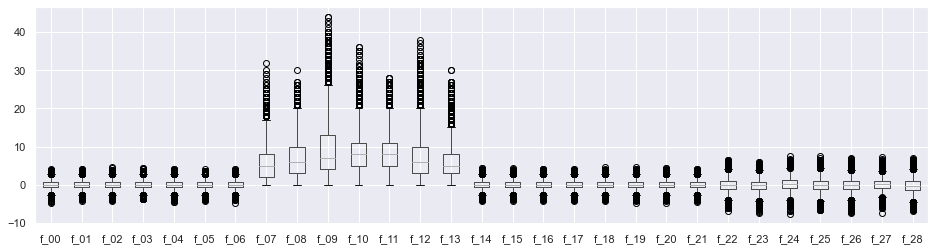

In [60]:
sure_samples.boxplot(figsize=(16,4))

In [67]:
def objective(trial, n_splits=10, shuffle=True, get_info=False):
    
    param = {        
        'verbose': 0,
        'random_state': seed,
        'loss_function': 'MultiClass',
        'task_type': 'GPU',
        'iterations': trial.suggest_int('iterations', 10, 1000, 10),
        'depth': trial.suggest_int('depth', 1, 8),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1),
        'random_strength': trial.suggest_uniform('random_strength', 1e-9, 10),
        'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0, 1),
        'border_count': trial.suggest_int('border_count', 1, 255),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 30),
    }
    
    model = cb.CatBoostClassifier(**param)
    
    kf = StratifiedKFold(n_splits=n_splits, shuffle=shuffle, random_state=seed)    
    
    scores = []
    models = []

    for train_index, test_index in kf.split(sure_samples, sure_y): 

        train_dataset = cb.Pool(
            data=sure_samples.iloc[train_index,:], 
            label=sure_y[train_index],
            cat_features=cat_features
        )
        
        eval_dataset = cb.Pool(
            data=sure_samples.iloc[test_index,:], 
            label=sure_y[test_index],
            cat_features=cat_features
        )
        
        model.fit(
            train_dataset,            
            early_stopping_rounds=200,
            verbose=0,            
        )

        y_test_pred = model.predict(eval_dataset).reshape(-1)
        
        score = metrics.adjusted_rand_score(
            labels_true=sure_y[test_index],
            labels_pred=y_test_pred
        )
        
        scores.append(score)
        models.append(model)

    scores = np.array(scores)
    
    if get_info:
        
        info = {
            'mean_score': np.mean(scores), 
            'score_std' : np.std(scores), 
            'scores': scores, 
            'models': models,
        }
        
        return info
    else:
        return np.mean(scores)

In [68]:
study = optuna.create_study(direction='maximize', study_name='catboost_on_unscaled_data_with_bgm_target')
study.optimize(objective, n_trials=10, show_progress_bar=True)

[I 2022-07-19 20:33:48,642] A new study created in memory with name: catboost_on_unscaled_data_with_bgm_target
C:\Users\yurit\anaconda3\envs\ml\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-07-19 20:36:07,079] Trial 0 finished with value: 0.9747780498290431 and parameters: {'iterations': 920, 'depth': 7, 'learning_rate': 0.30368574436796, 'random_strength': 7.155502366261009, 'bagging_temperature': 0.6622904518475742, 'border_count': 188, 'l2_leaf_reg': 13.224628864502117}. Best is trial 0 with value: 0.9747780498290431.
[I 2022-07-19 20:37:40,602] Trial 1 finished with value: 0.9817348150679059 and parameters: {'iterations': 430, 'depth': 8, 'learning_rate': 0.20013131009619078, 'random_strength': 8.094855774839385, 'bagging_temperature': 0.2711608188179271, 'border_count': 151, 'l2_leaf_reg': 0.06797013867996354}. Best is trial 1 with value: 0.9817348150679059.
[I 2022-07-19 20:38:45,958] Trial 2 finished with value: 0.9671649072727133 and parameters: {'iterations': 800, 'depth': 2, 'learning_rate': 0.5980230096554202, 'random_strength': 1.3523386839047493, 'bagging_temperature': 0.06362542370727264, 'border_count': 184, 'l2_leaf_reg': 0.41342723052560776}. Best

In [69]:
study.best_value

0.9852801094744323

In [70]:
study.best_params

{'iterations': 890,
 'depth': 5,
 'learning_rate': 0.16062407645322016,
 'random_strength': 5.445300603280031,
 'bagging_temperature': 0.358640620724898,
 'border_count': 241,
 'l2_leaf_reg': 0.20982796272270796}

In [71]:
info = objective(optuna.trial.FixedTrial(study.best_params), get_info=True)

In [72]:
best_models = info['models']

## A bag of CatBoost models for predictions

In [73]:
predict_proba = 0

for model in best_models:
    predict_proba += model.predict_proba(df.drop('id', axis=1))

In [74]:
predictions = np.argmax(predict_proba, axis=1)
predictions[:5]

array([5, 4, 5, 2, 3], dtype=int64)

In [75]:
submission = pd.read_csv('../../../Data/Tabular Playground Series/tabular-playground-series-jul-2022/sample_submission.csv')
submission['Predicted'] = predictions
submission.to_csv("submission.csv", index=False)

## Your submission scored 0.61418, which is not an improvement of your previous score. Keep trying!

### Leaderboard Score

<img src="bag_of_catboost_unscaled.png">